# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
csv_path = '/content/drive/My Drive/kickstarter_aggregated_data.csv'
json_path = '/content/drive/My Drive/kickstarter_aggregated_comments.json'

In [ ]:
import pandas as pd
import json

In [ ]:
df = pd.read_csv(csv_path, index_col=0)

In [ ]:
df.head()

,slug,percent_funded,pledged,goal,time_passed
15563,eme-events-made-easy,0.0000,0.0,37890.0,46 days 08:09:45
159052,encouragedme-a-gentle-push-to-keep-you-moving,0.0000,0.0,70000.0,41 days 07:23:41
14735,ignix,0.0025,10.0,400000.0,54 days 22:28:23
147550,coche-compi,0.0000,0.0,12100.0,21 days 15:26:17
149797,feco-the-footprint-economy,0.0000,0.0,25000.0,63 days 16:42:51


In [ ]:
with open(json_path, "r") as f:
  comments = json.load(f)

# Load DistilBERT Model

In [ ]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Use GPU if possible

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)
model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# Finetuning the Distilbert model

## Dataset generation

In [ ]:
prompts = [
    {
        "label": 1,
        "prompt": "Generate 20 Kickstarter comments from tech-savvy users who are excited to back a cutting-edge gadget on Kickstarter. Return them as a numbered list."
    },
    {
        "label": 1,
        "prompt": "Generate 20 comments from users new to Kickstarter who are curious and interested in funding a project for the first time. Return them as a numbered list."
    },
    {
        "label": 1,
        "prompt": "Write 20 comments from people who are enthusiastic about supporting eco-friendly or sustainable Kickstarter products. Return them as a numbered list."
    },
    {
        "label": 1,
        "prompt": "Generate 20 comments from board game fans who are excited to fund a new game project on Kickstarter. Return them as a numbered list."
    },
    {
        "label": 1,
        "prompt": "Give 20 Kickstarter comments from users who just pledged to grab the early bird deal and are excited. Return them as a numbered list."
    },
    {
        "label": 1,
        "prompt": "Write 20 comments from artistic users who support creative campaigns like music, comics, or films. Return them as a numbered list."
    },
    {
        "label": 1,
        "prompt": "Generate 20 comments from experienced Kickstarter users who have backed many campaigns and are happy to back this one too. Return them as a numbered list."
    },
    {
        "label": 1,
        "prompt": "Write 20 Kickstarter comments that show curiosity about features, rewards, or delivery dates — from users planning to back. Return them as a numbered list."
    },
    {
        "label": 1,
        "prompt": "Generate 20 supportive comments from people who know the creator personally and are pledging to help them succeed. Return them as a numbered list."
    },
    {
        "label": 1,
        "prompt": "Write 20 comments from fans of a company or creator who are returning to support their new Kickstarter campaign. Return them as a numbered list."
    },
    {
        "label": 0,
        "prompt": "Generate 20 comments from users who have backed Kickstarter projects before but are hesitant due to bad past experiences. Return them as a numbered list."
    },
    {
        "label": 0,
        "prompt": "Write 20 comments from users who think the campaign is too expensive and are unlikely to pledge. Return them as a numbered list."
    },
    {
        "label": 0,
        "prompt": "Generate 20 Kickstarter comments from users who think there are already better or cheaper alternatives in the market. Return them as a numbered list."
    },
    {
        "label": 0,
        "prompt": "Write 20 casual comments from users who are browsing Kickstarter and commenting but not planning to back. Return them as a numbered list."
    },
    {
        "label": 0,
        "prompt": "Generate 20 skeptical comments from users concerned about unrealistic goals, timelines, or credibility of the project. Return them as a numbered list."
    },
    {
        "label": 0,
        "prompt": "Write 20 comments from users who clearly say the product isn't for them (e.g. 'not my thing' or 'not interested'). Return them as a numbered list."
    },
    {
        "label": 0,
        "prompt": "Generate 20 comments from users expressing doubt about whether the project will deliver on time or at all. Return them as a numbered list."
    },
    {
        "label": 0,
        "prompt": "Write 20 comments that sound supportive of the idea but clearly state they won’t be backing it right now. Return them as a numbered list."
    },
    {
        "label": 0,
        "prompt": "Generate 20 brief or disengaged comments like 'cool', 'nice idea', or emoji-only — from users not planning to pledge. Return them as a numbered list."
    },
    {
        "label": 0,
        "prompt": "Write 20 Kickstarter comments that politely criticize the campaign's idea, execution, or value proposition. Return them as a numbered list."
    }
]

In [ ]:
import openai
import time
import pandas as pd
from tqdm import tqdm
import os
from google.colab import userdata


In [ ]:
client = openai.OpenAI(api_key=userdata.get("OPENAI_KEY"))  # This is how you now initialize the client

comments = []

for entry in tqdm(prompts):
    try:
        response = client.chat.completions.create(
            model="gpt-4o",  # or "gpt-3.5-turbo"
            messages=[
                {"role": "user", "content": entry["prompt"] + "\nReturn the 20 comments as a numbered list."}
            ],
            temperature=0.9,
            max_tokens=2500
        )

        content = response.choices[0].message.content

        for line in content.split("\n"):
            if line.strip() and '.' in line:
                text = line.split('.', 1)[1].strip()
                if text:
                    comments.append({"text": text, "label": entry["label"]})

        time.sleep(1)

    except Exception as e:
        print(f"Error on prompt: {entry['prompt'][:50]}... => {str(e)}")

100%|██████████| 20/20 [02:33<00:00,  7.66s/it]


In [ ]:
import pandas as pd

# Convert comments list to a DataFrame
df = pd.DataFrame(comments)

# Save to CSV
df.to_csv("comments_output.csv", index=False)

In [ ]:
from google.colab import files
files.download("comments_output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Finetune model

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
import pandas as pd

df = pd.DataFrame(comments)
df = df.dropna(subset=["text", "label"])  # Just in case

# Convert labels to int
df["label"] = df["label"].astype(int)

In [ ]:
from datasets import Dataset
from transformers import DistilBertTokenizerFast

# Convert DataFrame to HuggingFace Dataset
dataset = Dataset.from_pandas(df)

# Split into train/test
dataset = dataset.train_test_split(test_size=0.2)

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenize
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [ ]:
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer
import torch
import os
os.environ["WANDB_DISABLED"] = "true"
# Load model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./distilbert-finetuned-comments",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer
)

# Train the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-20-d466d79667c1>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.564300,0.375684
2,0.248100,0.171361
3,0.132700,0.134850


TrainOutput(global_step=120, training_loss=0.3150669535001119, metrics={'train_runtime': 338.0516, 'train_samples_per_second': 2.84, 'train_steps_per_second': 0.355, 'total_flos': 9686678526720.0, 'train_loss': 0.3150669535001119, 'epoch': 3.0})

In [ ]:
def get_sentiment_scores(comments, verbose=False):
    inputs = tokenizer(comments, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    row_sum = logits.abs().sum(dim=1, keepdim=True)
    normalized_logits = logits / row_sum

    # Positivity index scaled to [0, 1]
    positivity_index = (normalized_logits[:, 1] + 1) / 2

    if verbose:
        for i, comment in enumerate(comments):
            pos_score = positivity_index[i].item()
            sentiment = "positive" if pos_score > 0.5 else "negative"
            print(f"Comment: {comment}")
            print(f"  → Sentiment: {sentiment}, Positivity Index: {pos_score:.3f}")

    return positivity_index.cpu().numpy()  # or .tolist() if you want plain Python list

In [ ]:
def get_avg_sentiment_scores_for_slug(slug):
  comments_objs = comments.get(slug, [])
  if not comments_objs:
    return None

  # Extract text from the list of comment dicts
  comment_texts_not_creator = [
      c['comment'] for c in comments_objs
      if 'comment' in c
      and c['comment'].strip()
      and not c['is_creator']
  ]

  comment_texts_from_creator = [
      c['comment'] for c in comments_objs
      if 'comment' in c
      and c['comment'].strip()
      and not c['is_creator']
  ]

  if not comment_texts_not_creator:
      return None

  # Get weighted sentiment scores for each comment
  not_creator_scores = get_sentiment_scores(comment_texts_not_creator)

  # Return the average sentiment for this slug
  return sum(not_creator_scores) / len(not_creator_scores)

In [ ]:
def has_comments(slug):
  return bool(comments.get(slug))

projects_with_comments_df = df[df['slug'].apply(has_comments)]

projects_with_comments_df.shape[0]

85

In [ ]:
projects_with_comments_df['sentiment_score'] = projects_with_comments_df['slug'].apply(get_avg_sentiment_scores_for_slug)


Comment: an intersting idea! And how to change the photo?
  → Sentiment: negative, Positive: -0.459, Negative: 0.541
Comment: Can you also make it activated thru Homey and the fire brigade schedule (for NL)?
  → Sentiment: negative, Positive: -0.454, Negative: 0.546
Comment: Have you received feedback from your local fire departments?
  → Sentiment: negative, Positive: -0.459, Negative: 0.541
Comment: I hope we reach 81% total pledges
  → Sentiment: positive, Positive: 0.506, Negative: -0.494
Comment: Very impressed! It’s really neat to use! Any chance of integration into Apple Health any time soon?
  → Sentiment: positive, Positive: 0.513, Negative: -0.487
Comment: I been thinking about the USB A port... What is the charging spec for this port? 😇
  → Sentiment: negative, Positive: -0.455, Negative: 0.545
Comment: The hole for attaching the key chain shouldn't be in this shape. The root of the keychain will break off easily.
  → Sentiment: negative, Positive: -0.458, Negative: 0.542
Co

<ipython-input-64-584c9fea75f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  projects_with_comments_df['sentiment_score'] = projects_with_comments_df['slug'].apply(get_avg_sentiment_scores_for_slug)


In [ ]:
projects_with_comments_df.head()

,slug,percent_funded,pledged,goal,time_passed
26514,agora-the-social-network-for-gamers-to-find-an...,0.000000,0.0,7000.0,28 days 00:14:17
115856,encapsly-the-photo-projecting-phonecase,0.586667,176.0,30000.0,58 days 01:48:45
31683,emergency-house-number,0.455820,195.0,42780.0,50 days 01:06:06
94801,kwel-the-new-tiktok,0.677778,305.0,45000.0,31 days 11:35:54
44474,the-flare-fire-locator-and-aerial-rapid-respon...,0.361000,361.0,100000.0,47 days 19:49:19


In [ ]:
projects_with_comments_df['sentiment_score'] = projects_with_comments_df['sentiment_score'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

<ipython-input-65-4c051b3cc2cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  projects_with_comments_df['sentiment_score'] = projects_with_comments_df['sentiment_score'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)


In [ ]:
sorted_df = projects_with_comments_df.sort_values(by='sentiment_score', ascending=False)

In [ ]:
sorted_df.head()

,slug,percent_funded,pledged,goal,time_passed,sentiment_score
47906,ipason-yao-q27s-monitor-unlock-your-full-gamin...,926.438356,202890.0,21900.0,89 days 21:43:44,0.752110
44475,3d-flight-lab-printable-drone-gyro-v12,204.866667,3073.0,1500.0,135 days 18:50:55,0.745977
22780,wizards-chest,8.200000,410.0,5000.0,41 days 20:24:01,0.745975
63854,e-pisteme-space-immersive-stem-kits-on-all-thi...,100.280000,2507.0,2500.0,269 days 09:37:13,0.745839
94816,how-to-make-music-immersive,48.582960,10834.0,22300.0,263 days 10:05:23,0.745016


In [ ]:
mean_sentiment_score = sorted_df['sentiment_score'].mean()
sorted_df['sentiment_score'] = sorted_df['sentiment_score'].fillna(mean_sentiment_score)

# Build simple models based on sentiment score and comment count

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

## Prepare Data

Potential features to explore:
- comment count.

some random ones ig:
- is there a lot of back and forth between the (same) commenters and the shop owners.
- comment frequency (on top of just count)
- speed of reply... etc
- topic modelling: to detect themes like "product issues", etc ????

In [ ]:
def count_comments(slug):
    comments_objs = comments.get(slug, [])
    if not comments_objs:
        return 0
    return len(comments_objs)


In [ ]:
def count_comments_not_creator(slug):
    comments_objs = comments.get(slug, [])
    if not comments_objs:
        return 0
    comments_not_creator = [c for c in comments_objs if not c["is_creator"]]
    return len(comments_not_creator)

In [ ]:
from datetime import datetime

def get_comment_frequencies(slug):
    comments_objs = comments.get(slug, [])
    if not comments_objs:
        return 0.0

    # Extract timestamps of non-creator comments
    timestamps = [int(c["timestamp"]) for c in comments_objs if not c["is_creator"]]

    if not timestamps:
        return 0.0

    # Convert to datetime.date objects
    dates = [datetime.utcfromtimestamp(ts).date() for ts in timestamps]

    # Compute total number of days including inactive ones
    start_date = min(dates)
    end_date = max(dates)
    total_days = (end_date - start_date).days + 1  # +1 to include both start and end

    if total_days == 0:
        return float(len(dates))  # All comments on one day

    # Average comments per calendar day (including days with 0 comments)
    avg_per_day = len(dates) / total_days
    return avg_per_day


In [ ]:
def conversation_chain_stats(slug):
    comments_objs = comments.get(slug, [])
    if not comments_objs:
        return {
            "total_chains": 0,
            "avg_chain_length": 0,
            "max_chain_length": 0
        }

    chains = []
    current_chain = []

    for i, comment in enumerate(comments_objs):
        role = 'creator' if comment['is_creator'] else 'user'
        if not current_chain:
            current_chain.append(role)
        else:
            if role != current_chain[-1]:
                current_chain.append(role)
            else:
                if len(current_chain) > 1:
                    chains.append(len(current_chain))
                current_chain = [role]

    if len(current_chain) > 1:
        chains.append(len(current_chain))

    if not chains:
        return {
            "total_chains": 0,
            "avg_chain_length": 0,
            "max_chain_length": 0
        }

    return {
        "total_chains": len(chains),
        "avg_chain_length": sum(chains) / len(chains),
        "max_chain_length": max(chains)
    }

In [ ]:
simple_model_df = projects_with_comments_df.copy()

In [ ]:
simple_model_df['number_of_comments'] = simple_model_df['slug'].apply(count_comments_not_creator)

In [ ]:
simple_model_df['log_comments'] = np.log1p(simple_model_df['number_of_comments'])
simple_model_df['comments_square'] = np.square(simple_model_df['number_of_comments'])

In [ ]:
chain_metrics = simple_model_df['slug'].apply(conversation_chain_stats)

simple_model_df["total_chains"] = chain_metrics.apply(lambda x: x["total_chains"])
simple_model_df["avg_chain_length"] = chain_metrics.apply(lambda x: x["avg_chain_length"])
simple_model_df["max_chain_length"] = chain_metrics.apply(lambda x: x["max_chain_length"])

In [ ]:
simple_model_df['comment_frequency'] = simple_model_df['slug'].apply(get_comment_frequencies)
simple_model_df["comment_frequency"] = simple_model_df["comment_frequency"].fillna(0)

In [ ]:
simple_model_df["sentiment_score"] = simple_model_df["sentiment_score"].fillna(simple_model_df["sentiment_score"].quantile(0.2))

In [ ]:
simple_model_df['time_passed'] = pd.to_timedelta(simple_model_df['time_passed'], errors='coerce')

# Convert timedelta to total number of days (as float)
simple_model_df['time_passed_days'] = simple_model_df['time_passed'].dt.total_seconds() / 86400

simple_model_df['percent_funded_per_day'] = simple_model_df['percent_funded'] / (simple_model_df['time_passed_days'] + 1e-6)


In [ ]:
simple_model_df.drop(columns=['pledged', 'goal'])

,slug,percent_funded,time_passed,sentiment_score,number_of_comments,total_chains,avg_chain_length,max_chain_length,comment_frequency,time_passed_days,percent_funded_per_day
26514,agora-the-social-network-for-gamers-to-find-an...,0.000000,28 days 00:14:17,0.359407,0,0,0.000000,0,0.000000,28.009919,0.000000
115856,encapsly-the-photo-projecting-phonecase,0.586667,58 days 01:48:45,0.270712,1,0,0.000000,0,1.000000,58.075521,0.010102
31683,emergency-house-number,0.455820,50 days 01:06:06,0.426082,3,3,2.000000,2,3.000000,50.045903,0.009108
94801,kwel-the-new-tiktok,0.677778,31 days 11:35:54,0.359407,0,0,0.000000,0,0.000000,31.483264,0.021528
44474,the-flare-fire-locator-and-aerial-rapid-respon...,0.361000,47 days 19:49:19,0.430363,3,1,2.000000,2,3.000000,47.825914,0.007548
...,...,...,...,...,...,...,...,...,...,...,...
104917,czur-et-max-the-unprecedented-professional-boo...,71956.000000,106 days 17:43:46,0.432640,64,15,4.333333,17,3.764706,106.738727,674.132074
61847,longer-nano-duo-the-best-ai-laser-engraver,3869.135000,97 days 13:42:11,0.439380,42,10,3.600000,7,4.666667,97.570961,39.654575
26444,loomos-ai-glasses,40352.940000,53 days 20:05:57,0.374357,56,30,2.366667,5,9.333333,53.837465,749.532673
13571,xlaser-the-ultimate-4-in-1-laser-welding-revol...,3311.548082,111 days 21:41:59,0.450711,80,44,2.522727,5,6.666667,111.904155,29.592718


In [ ]:
simple_model_df.head()

,slug,percent_funded,pledged,goal,time_passed,sentiment_score,number_of_comments,total_chains,avg_chain_length,max_chain_length,comment_frequency,time_passed_days,percent_funded_per_day
26514,agora-the-social-network-for-gamers-to-find-an...,0.000000,0.0,7000.0,28 days 00:14:17,0.359407,0,0,0.0,0,0.0,28.009919,0.000000
115856,encapsly-the-photo-projecting-phonecase,0.586667,176.0,30000.0,58 days 01:48:45,0.270712,1,0,0.0,0,1.0,58.075521,0.010102
31683,emergency-house-number,0.455820,195.0,42780.0,50 days 01:06:06,0.426082,3,3,2.0,2,3.0,50.045903,0.009108
94801,kwel-the-new-tiktok,0.677778,305.0,45000.0,31 days 11:35:54,0.359407,0,0,0.0,0,0.0,31.483264,0.021528
44474,the-flare-fire-locator-and-aerial-rapid-respon...,0.361000,361.0,100000.0,47 days 19:49:19,0.430363,3,1,2.0,2,3.0,47.825914,0.007548


In [ ]:
from sklearn.preprocessing import StandardScaler

numeric_cols = simple_model_df.select_dtypes(include='number').columns

# Scale them
scaler = StandardScaler()
scaled_values = scaler.fit_transform(simple_model_df[numeric_cols])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = simple_model_df.select_dtypes(include='number')

#.drop(columns=['percent_funded', 'pledged', 'goal', 'avg_chain_length'])
scaler = StandardScaler()
X = simple_model_df[['number_of_comments']]
X_scaled = scaler.fit_transform(X)
y = simple_model_df['percent_funded_per_day']

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [ ]:
correlations = simple_model_df.corr(numeric_only=True)
correlations['percent_funded_per_day'].sort_values(ascending=False)

,percent_funded_per_day
percent_funded_per_day,1.000000
percent_funded,0.931500
total_chains,0.395846
number_of_comments,0.367224
comment_frequency,0.333279
max_chain_length,0.269821
avg_chain_length,0.120420
pledged,0.087185
goal,-0.036380
sentiment_score,-0.088226


## Build the model(s)

### Linear Regression

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
linear_model_y_pred = linear_model.predict(X_test)
print(linear_model_y_pred)

print(y_test)

[ 45.06612276   9.89532058 142.08902533  14.74646571  11.10810686
  77.81135238   9.89532058  11.10810686  13.53367943  15.95925199
  15.95925199  29.29990109  26.87432853  63.25791699  25.66154225
  36.57661879   9.89532058]
144426    101.231977
26514       0.000000
159097      2.660325
26785       1.910417
114370      0.412778
26444     749.532673
21619       1.453114
44475       1.508754
44474       0.007548
72503       5.570850
155450     19.508457
142970     24.397099
104929      0.916939
30134      99.861878
120951     29.051508
30085       3.347859
153120      8.785734
Name: percent_funded_per_day, dtype: float64


In [ ]:
mse = mean_squared_error(y_test, linear_model_y_pred)
r2 = r2_score(y_test, linear_model_y_pred)

print("Linear Regression Performance:")
print("Mean Squared Error:", mse)
print("R² Score:", r2)

Linear Regression Performance:
Mean Squared Error: 1790.1614397189055
R² Score: -265.34097651838


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [ ]:
tree_model_y_pred = tree_model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, tree_model_y_pred)
r2 = r2_score(y_test, tree_model_y_pred)

print("🌳 Decision Tree Performance:")
print("Mean Squared Error:", mse)
print("R² Score:", r2)

🌳 Decision Tree Performance:
Mean Squared Error: 39878195.70968994
R² Score: 0.04188599964859985


        sentiment_score  total_chains  max_chain_length  comment_frequency
26514          0.359407             0                 0                0.0
115856         0.270712             0                 0                1.0
31683          0.426082             3                 2                3.0
94801          0.359407             0                 0                0.0
44474          0.430363             1                 2                3.0
RMSE: 1.85
R² Score: 0.490
Mean: 5.947342308626157
Std Dev: 2.316976028694222


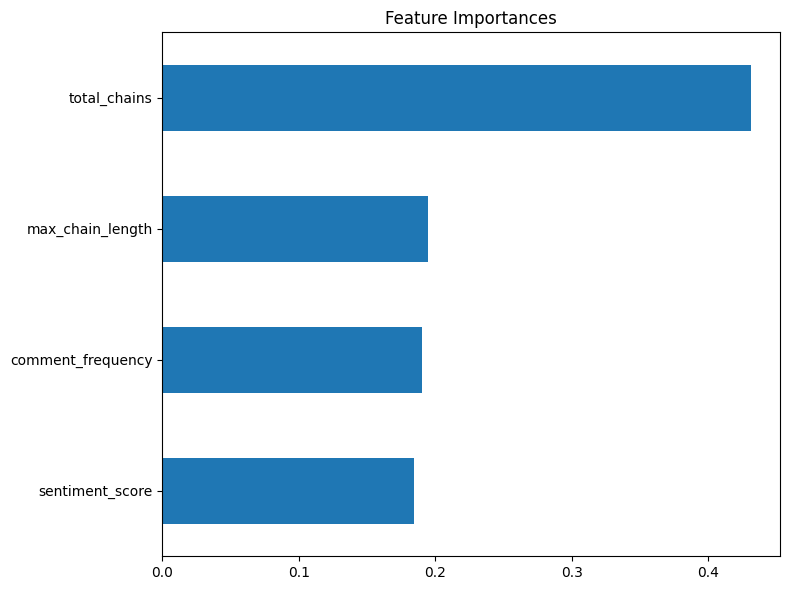

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# 1. Use all numerical features, excluding the target
X = simple_model_df.select_dtypes(include='number').drop(columns=['percent_funded', 'percent_funded_per_day', "number_of_comments", 'time_passed', 'time_passed_days', 'pledged', 'goal', 'avg_chain_length'])
# X = simple_model_df[["number_of_comments"]]
print(X.head())

# 2. Target variable
y = np.log1p(simple_model_df['percent_funded'])

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Initialize and fit Random Forest
rf_model = RandomForestRegressor(n_estimators=22, random_state=42)
rf_model.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {mse ** 0.5:.2f}")
print(f"R² Score: {r2:.3f}")
print("Mean:", y.mean())
print("Std Dev:", y.std())

# 6. Optional: Feature importances
import matplotlib.pyplot as plt

importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6), title="Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Save the trained model to a file
joblib.dump(rf_model, "random_forest_model.pkl")

['random_forest_model.pkl']

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    verbose=1,
    scoring='r2',
    n_jobs=-1
)

random_search.fit(X, y)
print("Best R²:", random_search.best_score_)
print("Best Params:", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best R²: -2.0665128963371986
Best Params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


        sentiment_score  total_chains  max_chain_length  comment_frequency
26514          0.359407             0                 0                0.0
115856         0.270712             0                 0                1.0
31683          0.426082             3                 2                3.0
94801          0.359407             0                 0                0.0
44474          0.430363             1                 2                3.0
RMSE: 1.52
R² Score: 0.297


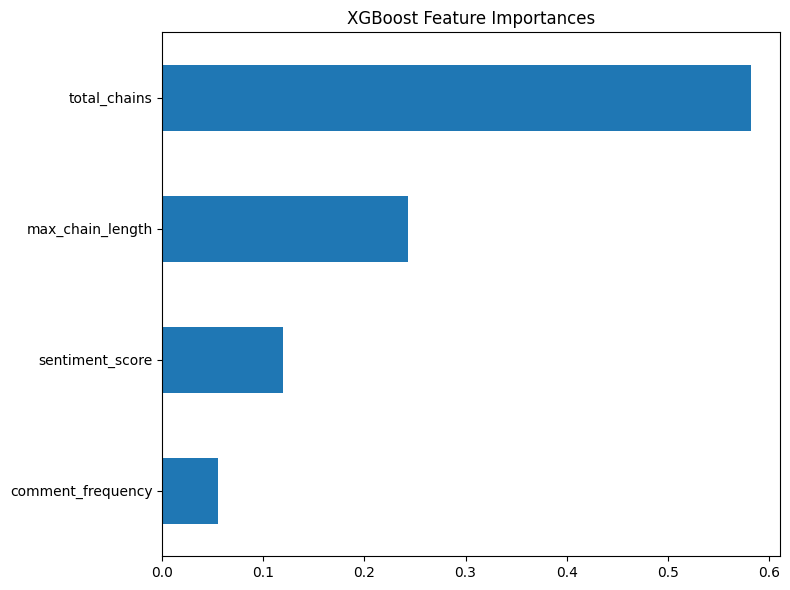

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# 1. Use all numerical features, excluding the target
X = simple_model_df.select_dtypes(include='number').drop(columns=[
    'percent_funded', 'percent_funded_per_day', 'number_of_comments',
    'time_passed', 'time_passed_days', 'pledged', 'goal', 'avg_chain_length'
])
print(X.head())

# 2. Target variable
y = np.log1p(simple_model_df['percent_funded_per_day'])

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Initialize and fit XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='reg:squarederror',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {mse ** 0.5:.2f}")
print(f"R² Score: {r2:.3f}")

# 6. Feature importances
importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6), title="XGBoost Feature Importances")
plt.tight_layout()
plt.show()